<a href="https://colab.research.google.com/github/bramadi/Data-Science-for-Biomedical-Data-Analysis/blob/main/Final_Gene_Clustering_Explained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

To cluster genes, instead of samples, we need to keep the objects as rows instead of transposing the data. When loading data, do not transpose it but do make sure to eliminate non numeric data from the main matrix and keep the gene and sample labels in variables that later can be used.

In [ ]:
#Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

#load data
df_load = pd.read_table('https://raw.githubusercontent.com/PineBiotech/omicslogic/master/CellLines_ExprData_marked.txt',sep='\t',header=(0)) 
labels_list = df_load.loc[[0]] 

#save sample names and clean them
#sample_names = df_load.loc[0] 
sample_names = list(df_load)[1:] 
labels = np.unique(labels_list) 
labels = np.delete(labels, np.where(labels == 'Group')) 

#save gene Ids and clean them
geneids = df_load['id']
geneids = geneids.drop([0]) 

#clean data
data=df_load.drop([0]) 
data=data.drop(['id'], axis=1) 
datafinal = data.astype(float)

#will be used later on to add cluster IDs
df_load = df_load.drop(0, axis=0)

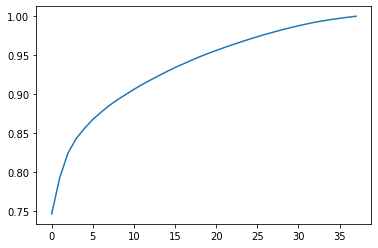

In [ ]:
#first, we are going to explore the data (without transposing as before)
from sklearn.decomposition import PCA

logD = np.log(datafinal+1)
logD.describe()

pca_all = PCA().fit(datafinal)
plt.plot(np.cumsum(pca_all.explained_variance_ratio_))

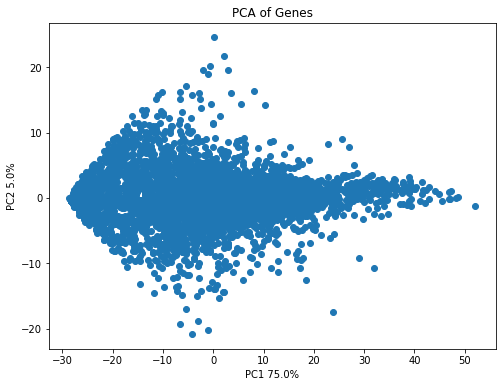

In [ ]:
#prepare a scatterplot of genes based on PC1 and PC2
X_pca = pca_all.transform(datafinal)
PC1 = 0 
PC2 = 1 
plt.figure(figsize=(8,6))
plt.xlabel(f'PC1 {round(pca_all.explained_variance_ratio_[0],2)*100}%')
plt.ylabel(f'PC2 {round(pca_all.explained_variance_ratio_[1],2)*100}%')
plt.title('PCA of Genes')

plt.scatter(X_pca[:,0],X_pca[:,1])
plt.show() 

In [ ]:
#load the sklearn cluster library Kmeans 
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4)
kmeans.fit(datafinal)
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300, n_clusters=3, n_init=10, n_jobs=1, precompute_distances ='auto', random_state=None, tol=0.0001, verbose=0)
flabels = kmeans.predict(datafinal)
centroids = kmeans.cluster_centers_

d = {'GeneIds':geneids, 'Kmeans':flabels, 'PC1':X_pca[:,0], 'PC2':X_pca[:,1]}
df = pd.DataFrame(d)

#check 
print(df)

              GeneIds  Kmeans        PC1       PC2
1     ENSG00000000419       1   6.553436 -0.372788
2     ENSG00000001036       1   4.579762  1.339591
3     ENSG00000001084       0   1.906375  0.750737
4     ENSG00000001497       1   4.376390  0.526701
5     ENSG00000001617       0   1.313118 -5.746566
...               ...     ...        ...       ...
6908  ENSG00000270016       2 -27.494870 -0.602334
6909  ENSG00000270149       0  -3.346159 -2.427103
6910  ENSG00000270161       0  -2.640483 -1.564889
6911  ENSG00000270168       2 -14.333634 -2.112777
6912  ENSG00000270170       0   0.486798 -0.328288

[6912 rows x 4 columns]


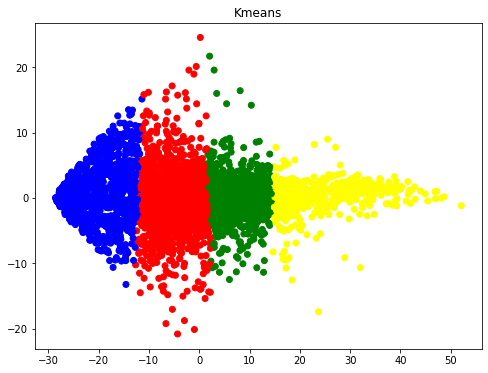

In [ ]:
plt.figure(figsize=(8,6))
plt.title('Kmeans')
colors = {0:'red', 1:'green', 2:'blue', 3:'yellow'}
plt.scatter(df['PC1'],df['PC2'], c=df['Kmeans'].map(colors), label=colors)
plt.show()

Let's plot intertia for k-means to see how "good" the clustering is. Inertia measures how well a dataset was clustered by K-Means. It is calculated by measuring the distance between each data point and its centroid, squaring this distance, and summing these squares across one cluster.
A good model is one with low inertia AND a low number of clusters (K). However, this is a tradeoff because as K increases, inertia decreases. To find the optimal K for a dataset, use the Elbow method; find the point where the decrease in inertia begins to slow. K=3 is the “elbow” of this graph.

In [ ]:
#K-means evaluation inertia
print(kmeans.inertia_)

525760.4254964165


This is a very high number for 4 clusters, so we can evaluate what number of clusters would reduce the inertia and select the number of clusters based on the "elbow method"

In [ ]:
#check param
df1 = pd.DataFrame()

#create a dataframe with noise and number of components
for i in range (2,20):
  kmeans_m = KMeans(n_clusters=i).fit(datafinal)
  df1 = df1.append({'clust':i,'inertia': kmeans_m.inertia_}, ignore_index=True)

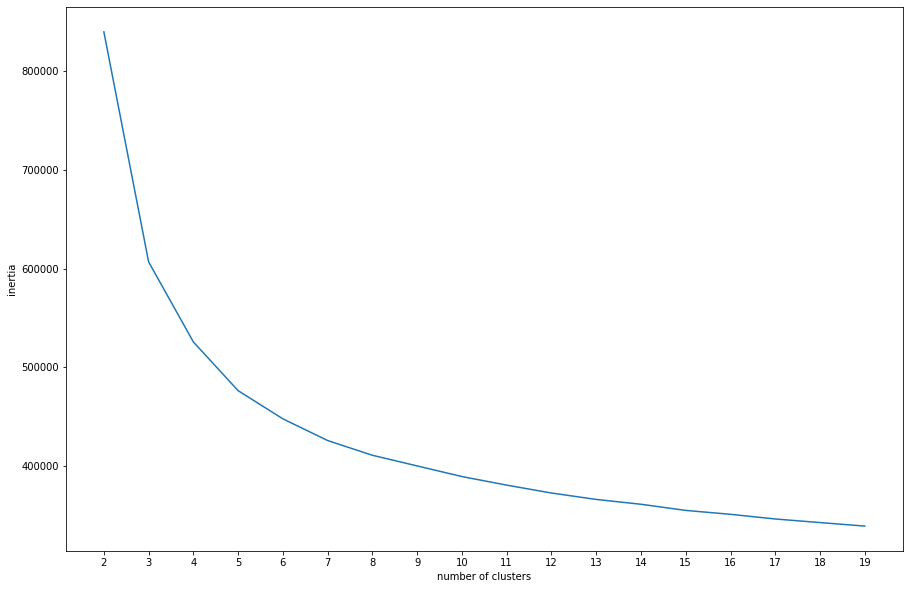

In [ ]:
#plot inertia across cluster numbers
plt.figure(figsize=(15, 10))
plt.plot(df1.clust, df1.inertia)
plt.xlabel('number of clusters')
plt.ylabel('inertia')
plt.xticks(np.arange(min(df1.clust), max(df1.clust)+1, 1.0));

Based on inertia, we can select the number of clusters as 6, however this parameter is not comparable across all types of clustering so to evaluate this further, let's try to use silhoette score which we can calculate for all types of clsutering.

The Silhouette Coefficient is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample. The Silhouette Coefficient for a sample is (b - a) / max(a, b). To clarify, b is the distance between a sample and the nearest cluster that the sample is not a part of. Note that Silhouette Coefficient is only defined if number of labels is 2 <= n_labels <= n_samples - 1.

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html

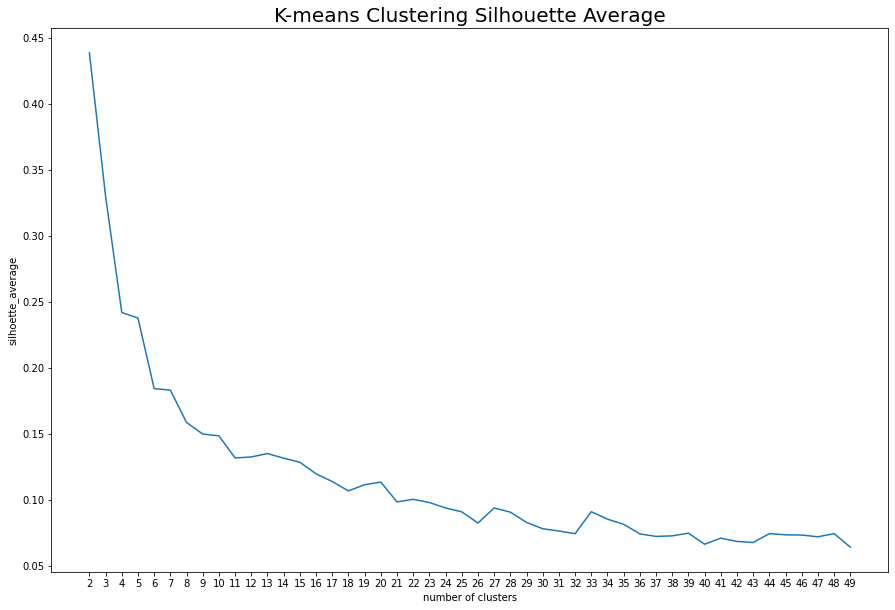

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score

df_scores_kmeans = pd.DataFrame()

#for loop to get silhouette score for clusters 2 to 20
for i in range (2,50):
  kmeans = KMeans(n_clusters=i)
  cluster_labels = kmeans.fit_predict(datafinal)
  silhouette_avg = silhouette_score(datafinal, cluster_labels)
  df_scores_kmeans = df_scores_kmeans.append({'clust':i,'silhouette_avg': 
                                              silhouette_avg}, ignore_index=True)

plt.figure(figsize=(15, 10))
plt.plot(df_scores_kmeans.clust, df_scores_kmeans.silhouette_avg)
plt.xlabel('number of clusters')
plt.ylabel('silhoette_average')
plt.title("K-means Clustering Silhouette Average", fontsize=20)
plt.xticks(np.arange(2, 50, 1.0));

Based on this score, it looks like 11 is a good number of clusters to use

In [ ]:
kmeans = KMeans(n_clusters=11)
kmeans.fit(datafinal)

#KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300, n_clusters=11, n_init=10, 
#       n_jobs=1, precompute_distances ='auto', random_state=None, tol=0.0001)

flabels = kmeans.predict(datafinal)

pd.unique(flabels)

array([ 2,  7,  8,  0,  4,  6, 10,  9,  5,  1,  3], dtype=int32)

[Text(0, 0.5, 'PC2 5.0%'), Text(0.5, 0, 'PC1 70.0%')]

<Figure size 576x432 with 0 Axes>

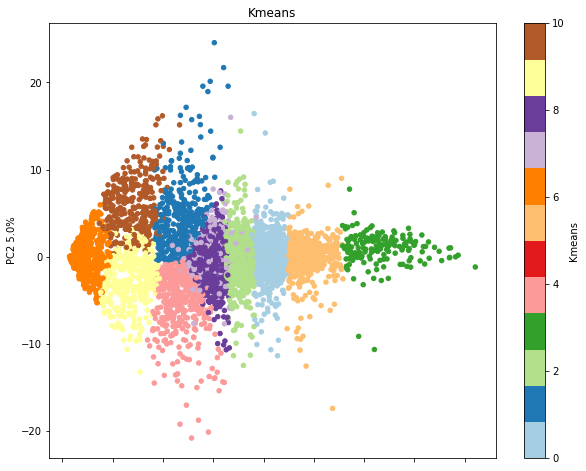

In [ ]:
#prepare a dataframe by adding cluster numbers to each gene ID
d = {'GeneIds':geneids, 'Kmeans':flabels, 'PC1':X_pca[:,0], 'PC2':X_pca[:,1]}
df_1 = pd.DataFrame(d)

plt.figure(figsize=(8,6))
df_1.plot.scatter(x='PC1', y='PC2', c='Kmeans', 
                cmap='Paired', figsize=(10,8), 
                title='Kmeans').set(
                    xlabel=f'PC1 {round(pca_all.explained_variance_ratio_[0],1)*100}%', 
                    ylabel=f'PC2 {round(pca_all.explained_variance_ratio_[1],2)*100}%',)
              

In [ ]:
for i in range(0, 11): 
  print("cluster %s has %s genes" % (i, len(df_1[df_1['Kmeans'] == i])))

cluster 0 has 930 genes
cluster 1 has 451 genes
cluster 2 has 1334 genes
cluster 3 has 167 genes
cluster 4 has 454 genes
cluster 5 has 484 genes
cluster 6 has 580 genes
cluster 7 has 738 genes
cluster 8 has 1079 genes
cluster 9 has 381 genes
cluster 10 has 314 genes


As you can see, the number of genes in each cluster is very high. Later on, we will explore how genes in each cluster look across samples

Now let's check density based clustering. Out of the 3 available on scikit spectral will take a very long time to perform clustering because of so many objects (n is high). Therefore, we will try DBSCAN and OPTICS. OPTICS is very similar to DBSCAN but we will use the xi method instead of DBSCAN for Optics. For DBSCAN it is important to play around with the epsilon and minimum number of samples in each cluster to optimize for performance and number of clsuters not equal to -1 (noise)

In [ ]:
#load DBScan
from sklearn.cluster import DBSCAN
dbscan_m = DBSCAN(eps=3.7,min_samples=10).fit(datafinal)
dbscan_m.labels_

array([-1, -1, -1, ..., -1, -1,  0])

In [ ]:
#OPTICS clustering method - similar to DBSCAN
from sklearn.cluster import OPTICS
optics_m = OPTICS(min_samples=10, max_eps=4).fit(datafinal)
optics_m.labels_

array([-1, -1, -1, ..., -1, -1,  0])

In [ ]:
d = {'GeneIds':geneids, 'Kmeans':flabels, 'DBScan':dbscan_m.labels_, 'OPTICS':optics_m.labels_, 'PC1':X_pca[:,0], 'PC2':X_pca[:,1]}
df = pd.DataFrame(d)

print(df['DBScan'].unique())
print(df['OPTICS'].unique())

[-1  0  2  1  4  3  5]
[-1  0  5  2  1  3  6  4]


Let us now check how many genes are in each cluster

In [ ]:
print("DBSCAN clustering results show:")
for i in range(-1, 5): 
  print("cluster %s has %s genes" % (i, len(df[df['DBScan'] == i])))

print("\nOPTICS clustering results show:")
for i in range(-1, 5): 
  print("cluster %s has %s genes" % (i, len(df[df['OPTICS'] == i])))

DBSCAN clustering results show:
cluster -1 has 4946 genes
cluster 0 has 1660 genes
cluster 1 has 232 genes
cluster 2 has 44 genes
cluster 3 has 8 genes
cluster 4 has 6 genes

OPTICS clustering results show:
cluster -1 has 4325 genes
cluster 0 has 2449 genes
cluster 1 has 11 genes
cluster 2 has 12 genes
cluster 3 has 14 genes
cluster 4 has 11 genes


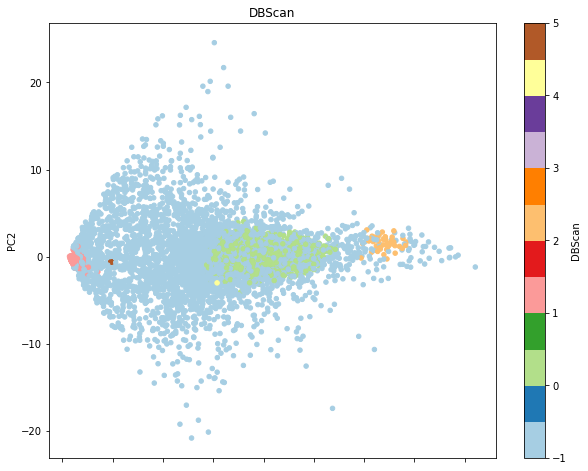

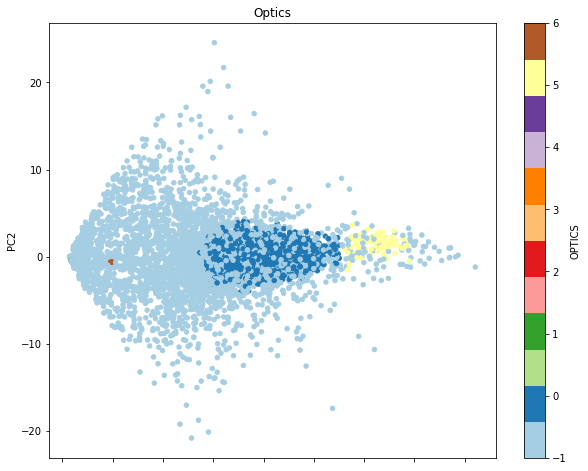

In [ ]:
df.plot.scatter(x='PC1',y='PC2', c='DBScan', cmap='Paired', figsize=(10,8), title='DBScan')
df.plot.scatter(x='PC1',y='PC2', c='OPTICS', cmap='Paired', figsize=(10,8), title='Optics')

**Remove clusters (Looks like Noise)**

In the scatterplot of DBScan, it looks a lot of noise (with cluster =  -1). Let's try to remove and then again visualize it.


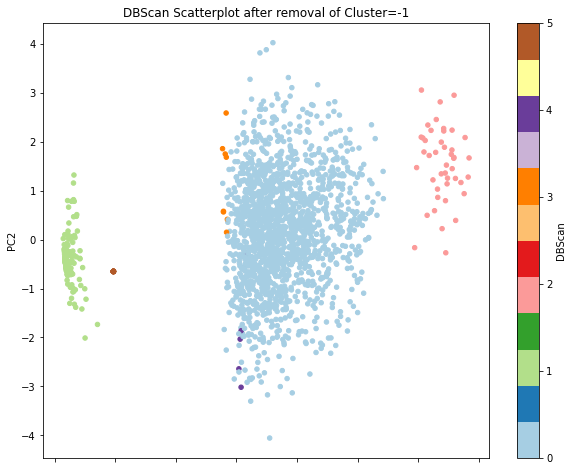

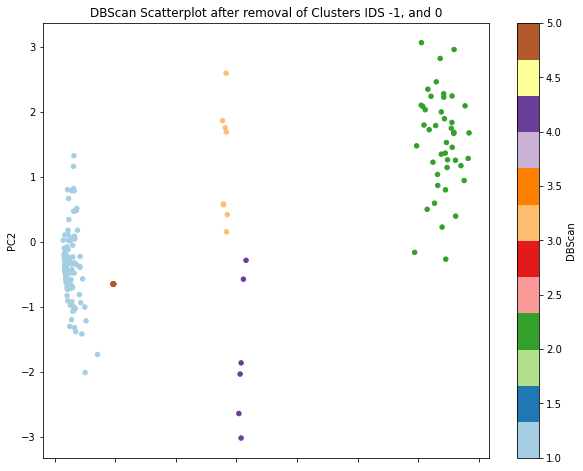

In [ ]:
#Remove columns KMeans and OPTICS columns
df_db = df.drop(["Kmeans", 'OPTICS'], axis=1)
#df_db.head()

#Remove cluster from data having value =-1
df_db1 = df_db[(df_db['DBScan'] != -1)]


df_db1.plot.scatter(x='PC1',y='PC2', c='DBScan', 
                    cmap='Paired', figsize=(10,8), title='DBScan Scatterplot after removal of Cluster=-1');


#Extract clusters only having id above 0
df_db2 = df_db[(df_db['DBScan'] > 0)]

df_db2.plot.scatter(x='PC1',y='PC2', c='DBScan', 
                    cmap='Paired', figsize=(10,8), 
                    title='DBScan Scatterplot after removal of Clusters IDS -1, and 0');



**Create a new dataframe with Cluster information and gene Expression values**

Create a new dataframe, which contains Cluster Groups from cluster types and coressponding genes expression among samples

In [ ]:
#Dataframe containing Genes and corresponding Cluster groups from three techniques
dd2 = df

#set index for dataframe
dd2.set_index('GeneIds', inplace=True)

#Data containing gene expression for all samples
df_load1 = df_load

#set index for dataframe
df_load1.set_index('id', inplace=True)

#Merge 2 dataframe based on index
df_full1 = pd.concat([dd2, df_load1], axis=1)

#Convert into integer
df_full1 = df_full1.astype(float)

#view data
df_full1.head()

,Kmeans,DBScan,OPTICS,PC1,PC2,600MPE,AU565,BT474,BT483,BT549,CAMA1,EFM192A,EFM192B,EFM192C,HCC1143,HCC1395,HCC1419,HCC1428,HCC1569,HCC1806,HCC1937,HCC1954,HCC202,HCC3153,HCC70,JIMT1,LY2,MCF10A,MCF10F,MCF12A,MCF7,MDAMB134VI,MDAMB175VII,MDAMB231,MDAMB361,MDAMB453,MX1,SKBR3,SUM1315MO2,SUM149PT,SUM225CWN,SUM229PE,SUM52PE
ENSG00000000419,2.0,-1.0,-1.0,6.553436,-0.372788,5.32,5.30,6.64,5.60,6.61,5.24,6.66,6.62,6.41,5.19,6.16,7.29,4.78,6.14,5.66,5.80,6.20,4.69,6.50,5.49,7.29,5.23,5.63,4.82,5.64,6.07,4.79,6.25,5.19,5.80,4.63,5.98,6.19,4.97,4.15,5.82,6.40,4.67
ENSG00000001036,2.0,-1.0,-1.0,4.579762,1.339591,6.11,4.80,4.47,4.99,6.94,5.00,5.11,5.42,4.58,4.74,6.03,5.47,4.32,6.16,5.89,5.37,6.01,4.72,5.17,5.96,6.35,5.02,5.31,6.37,5.24,6.29,5.81,4.16,6.56,5.91,5.19,4.00,5.48,4.14,5.90,5.51,5.14,6.22
ENSG00000001084,7.0,-1.0,-1.0,1.906375,0.750737,5.78,4.01,5.14,5.11,3.63,5.93,4.11,3.68,3.23,5.01,5.81,4.50,5.17,5.61,6.19,5.02,6.79,5.97,4.77,5.85,4.78,4.27,6.80,6.25,4.50,5.08,5.21,4.24,4.12,6.00,4.16,3.19,4.29,3.95,5.26,6.63,4.38,6.38
ENSG00000001497,2.0,0.0,0.0,4.376390,0.526701,4.93,6.16,5.36,5.10,6.16,5.50,6.10,6.88,5.99,6.69,5.03,5.33,6.46,4.99,5.49,5.47,5.95,4.04,4.63,4.97,6.12,4.77,5.31,4.79,5.62,5.11,5.34,4.20,5.47,3.92,5.14,5.95,4.74,4.95,5.26,4.69,6.16,5.11
ENSG00000001617,8.0,-1.0,-1.0,1.313118,-5.746566,4.06,7.53,4.70,6.69,3.30,5.39,6.55,6.41,5.26,1.76,3.94,4.74,4.67,2.71,3.33,5.04,5.33,5.50,5.05,5.83,3.86,7.31,5.13,5.15,5.23,5.51,6.76,5.12,1.12,5.49,7.74,1.38,6.81,1.71,4.80,3.80,5.59,5.27


**Visualize Data using Specific tuype of Clusters**

Let's visualize data based on specific cluster classes. Here, we are visualizing using DBScan first. One can visualize using any cluster type

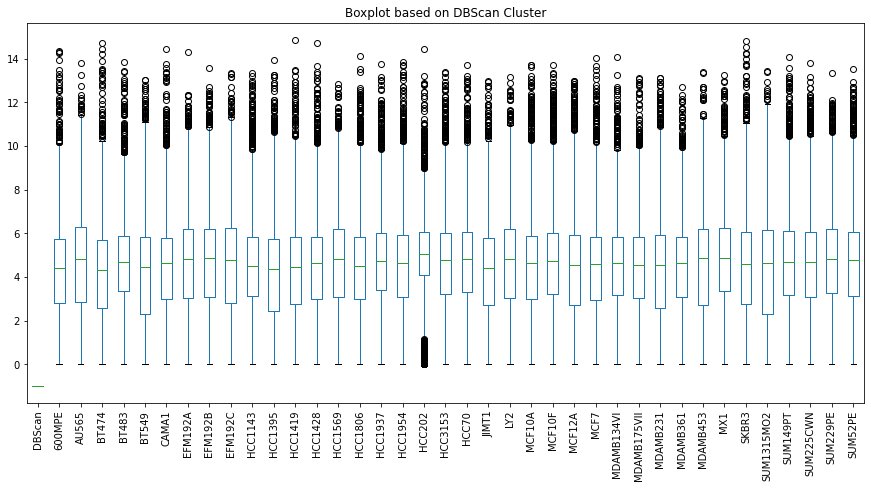

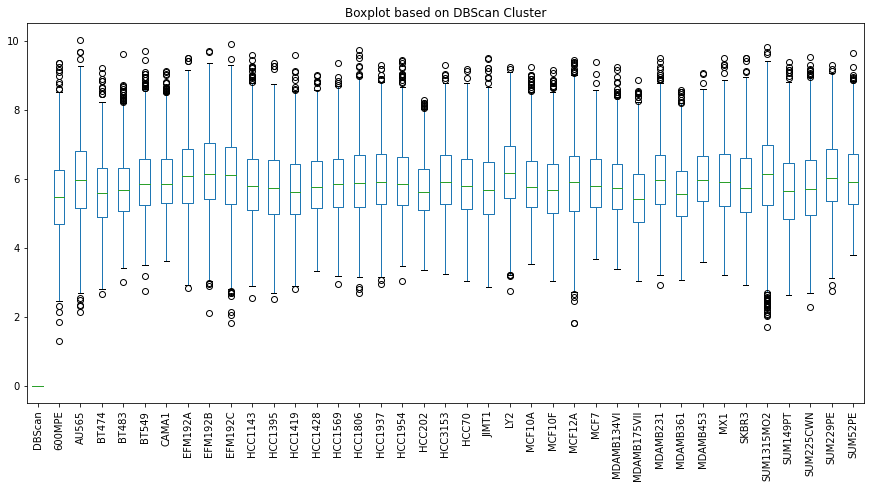

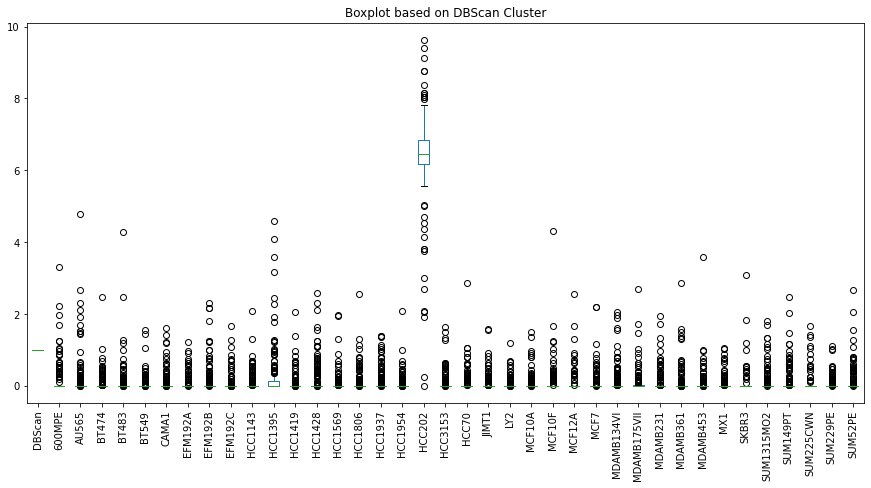

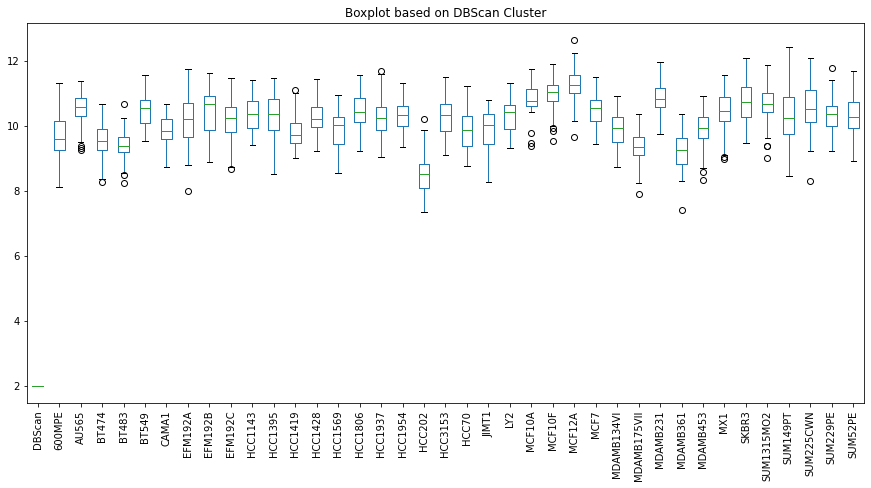

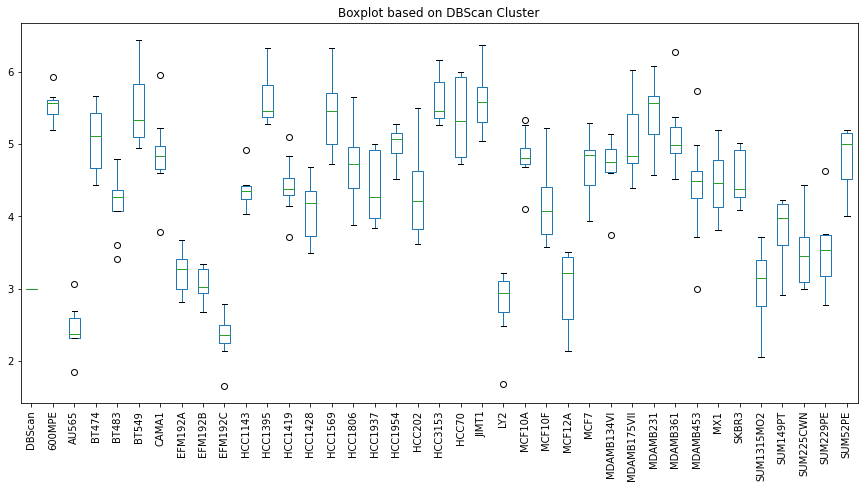

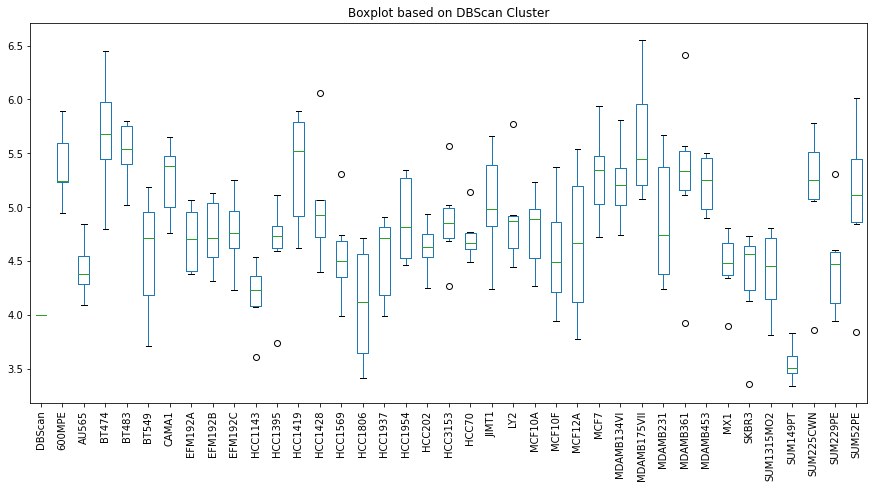

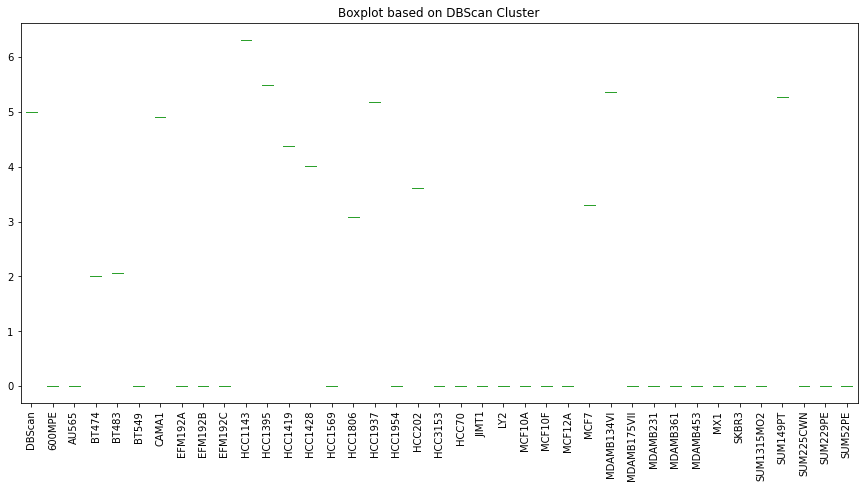

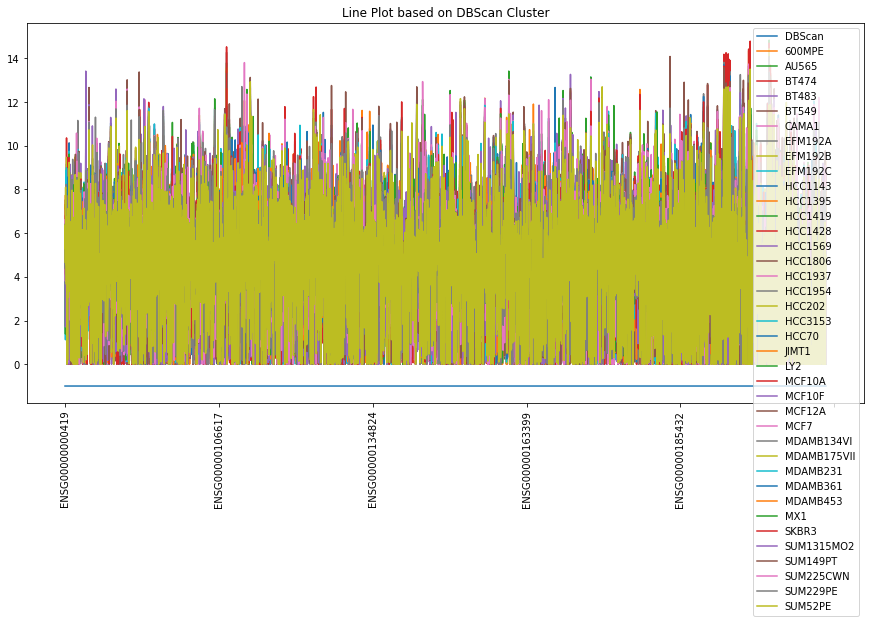

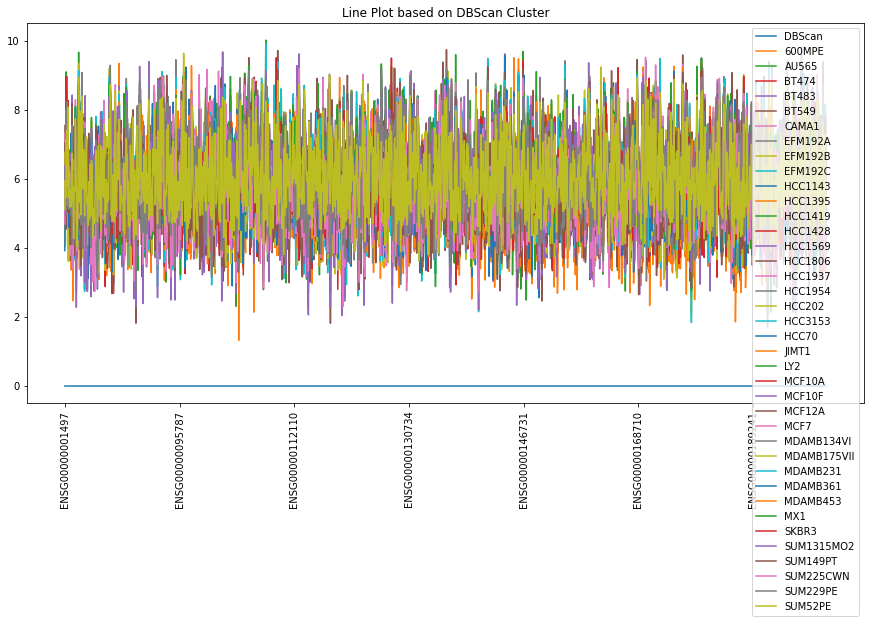

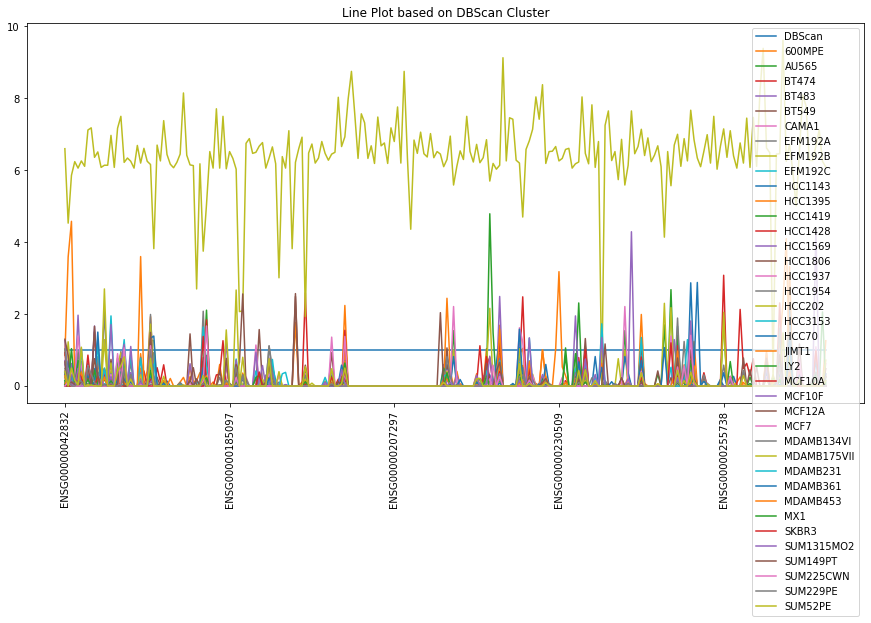

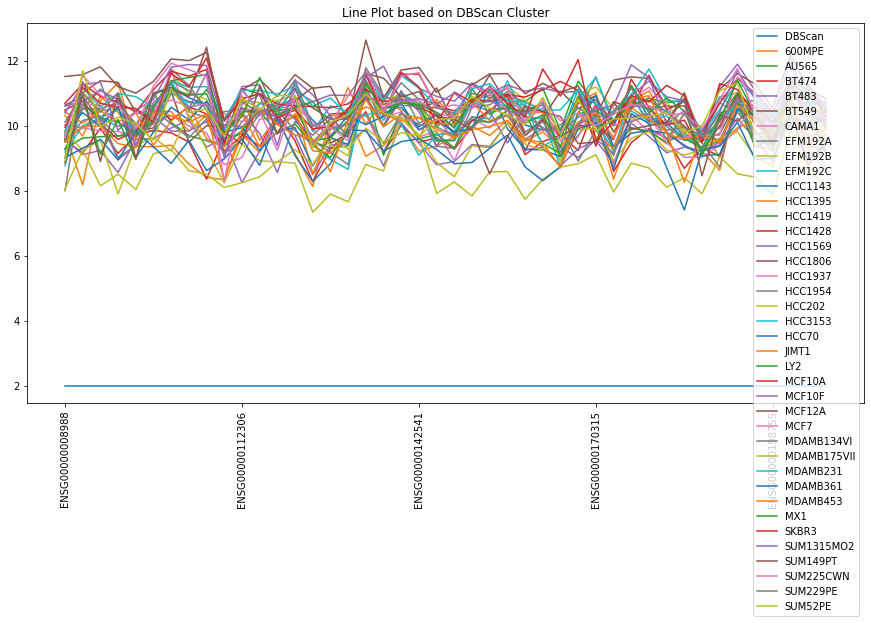

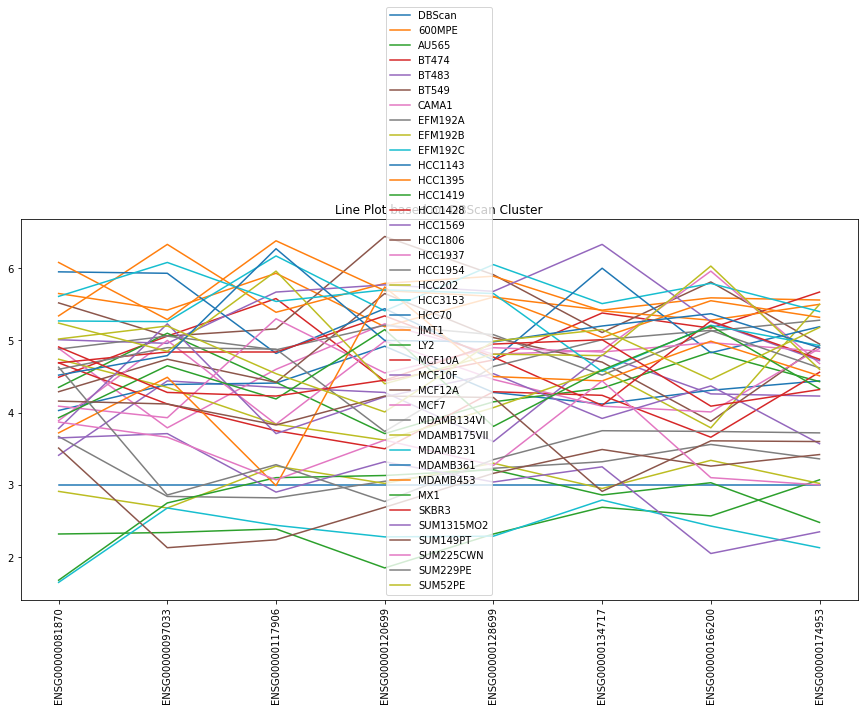

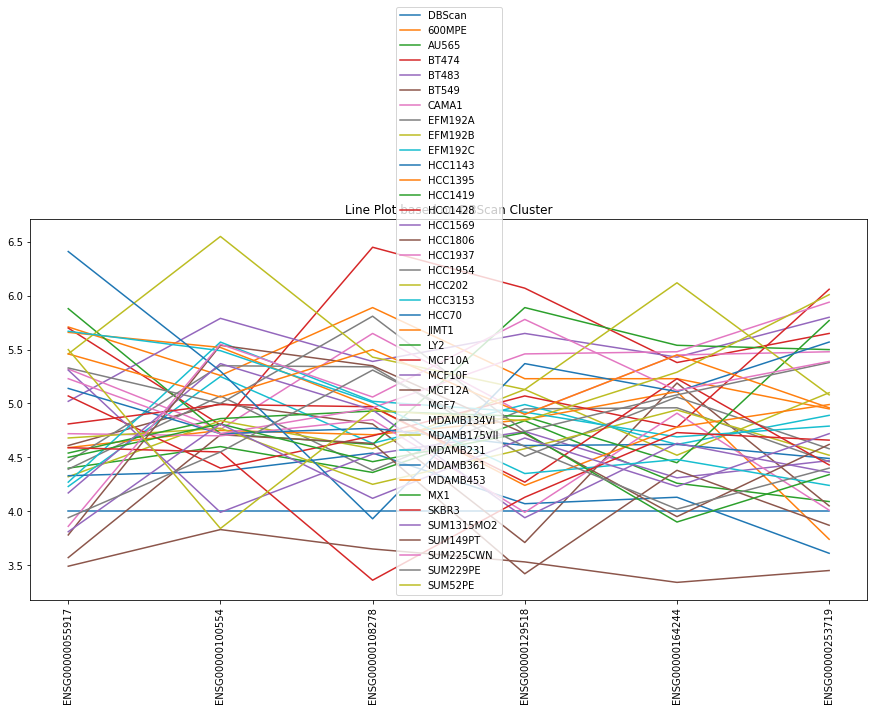

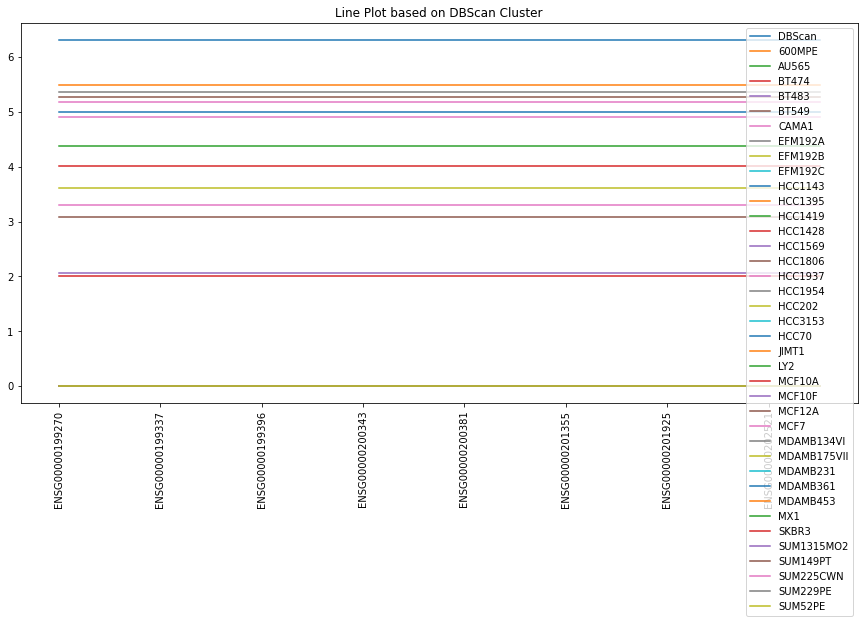

In [ ]:
#Extract data for 1 type of cluster
df_full_db = df_full1.drop(['Kmeans', 'OPTICS', 'PC1', 'PC2'], axis=1)


#Boxplot plot
df_full_db.groupby(['DBScan']).plot.box(figsize=(15,7), rot=90,  title='Boxplot based on DBScan Cluster');

#line plot
df_full_db.groupby(['DBScan']).plot(figsize=(15,7), rot=90, title='Line Plot based on DBScan Cluster');


**Create a dataframe for specific cluster**

Next to visulalize which cluster genes much better (i.e. A clusters containing genes having similar expression patterns among samples). Thus, Here, first, we can extract gene expression data for specific cluster. For instance, here, we will obtain data for cluster from each clustering type.

**Note: **you can look at each cluster one by one

In [ ]:
#Extract genes expression data for KMean First Cluster, i.e. Cluster =0
Clust1 = df_full1[df_full1['Kmeans'] == 2]
Clust2 = df_full1[df_full1['DBScan'] == 2]
Clust3 = df_full1[df_full1['OPTICS'] == 2]

#Remove/drop extra columns
nd1 = Clust1.drop([ 'PC1', 'PC2', 'DBScan',  'OPTICS' ], axis=1)
nd2 = Clust2.drop([ 'PC1', 'PC2', 'Kmeans',  'OPTICS' ], axis=1)
nd3 = Clust3.drop([ 'PC1', 'PC2', 'Kmeans',  'DBScan' ], axis=1)


#Take first 10 genes (Note: you can take all genes of a cluster,)
nd10_k = nd1.head(10)
nd10_d = nd2.head(10)
nd10_o = nd3.head(10)


#Transpose data
nd10_k_t = nd10_k.T
nd10_d_t = nd10_d.T
nd10_o_t = nd10_o.T

# Convert into Integer
nd10_k_t=nd10_k_t.astype(float)
nd10_d_t=nd10_d_t.astype(float)
nd10_o_t=nd10_o_t.astype(float)

#remove Fist row containing cluster value
nd10_k_t1 = nd10_k_t.iloc[1:]
nd10_d_t1 = nd10_d_t.iloc[1:]
nd10_o_t1 = nd10_o_t.iloc[1:]


nd10_k_t1.head()

,ENSG00000000419,ENSG00000001036,ENSG00000001497,ENSG00000001630,ENSG00000002549,ENSG00000003756,ENSG00000004487,ENSG00000005007,ENSG00000005194,ENSG00000005486
600MPE,5.32,6.11,4.93,6.74,5.13,6.98,4.92,4.97,4.14,4.78
AU565,5.30,4.80,6.16,5.15,4.96,5.05,6.19,6.17,6.12,7.08
BT474,6.64,4.47,5.36,6.14,4.72,6.13,5.61,5.12,5.55,5.97
BT483,5.60,4.99,5.10,5.27,5.80,6.16,5.50,5.29,5.45,6.46
BT549,6.61,6.94,6.16,3.88,5.57,5.86,6.35,5.25,5.77,4.84


([<matplotlib.axis.XTick at 0x7fdcc0d616d0>,
 [Text(0, 0, '600MPE'),
  Text(0, 0, 'AU565'),
  Text(0, 0, 'BT474'),
  Text(0, 0, 'BT483'),
  Text(0, 0, 'BT549'),
  Text(0, 0, 'CAMA1'),
  Text(0, 0, 'EFM192A'),
  Text(0, 0, 'EFM192B'),
  Text(0, 0, 'EFM192C'),
  Text(0, 0, 'HCC1143'),
  Text(0, 0, 'HCC1395'),
  Text(0, 0, 'HCC1419'),
  Text(0, 0, 'HCC1428'),
  Text(0, 0, 'HCC1569'),
  Text(0, 0, 'HCC1806'),
  Text(0, 0, 'HCC1937'),
  Text(0, 0, 'HCC1954'),
  Text(0, 0, 'HCC202'),
  Text(0, 0, 'HCC3153'),
  Text(0, 0, 'HCC70'),
  Text(0, 0, 'JIMT1'),
  Text(0, 0, 'LY2'),
  Text(0, 0, 'MCF10A'),
  Text(0, 0, 'MCF10F'),
  Text(0, 0, 'MCF12A'),
  Text(0, 0, 'MCF7'),
  Text(0, 0, 'MDAMB134VI'),
  Text(0, 0, 'MDAMB175VII'),
  Text(0, 0, 'MDAMB231'),
  Text(0, 0, 'MDAMB361'),
  Text(0, 0, 'MDAMB453'),
  Text(0, 0, 'MX1'),
  Text(0, 0, 'SKBR3'),
  Text(0, 0, 'SUM1315MO2'),
  Text(0, 0, 'SUM149PT'),
  Text(0, 0, 'SUM225CWN'),
  Text(0, 0, 'SUM229PE'),
  Text(0, 0, 'SUM52PE')])

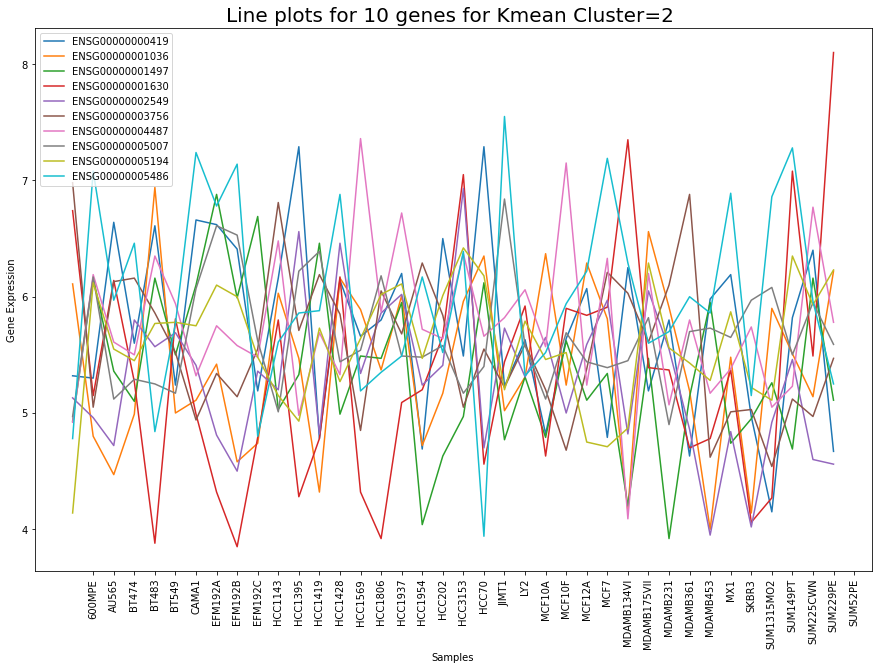

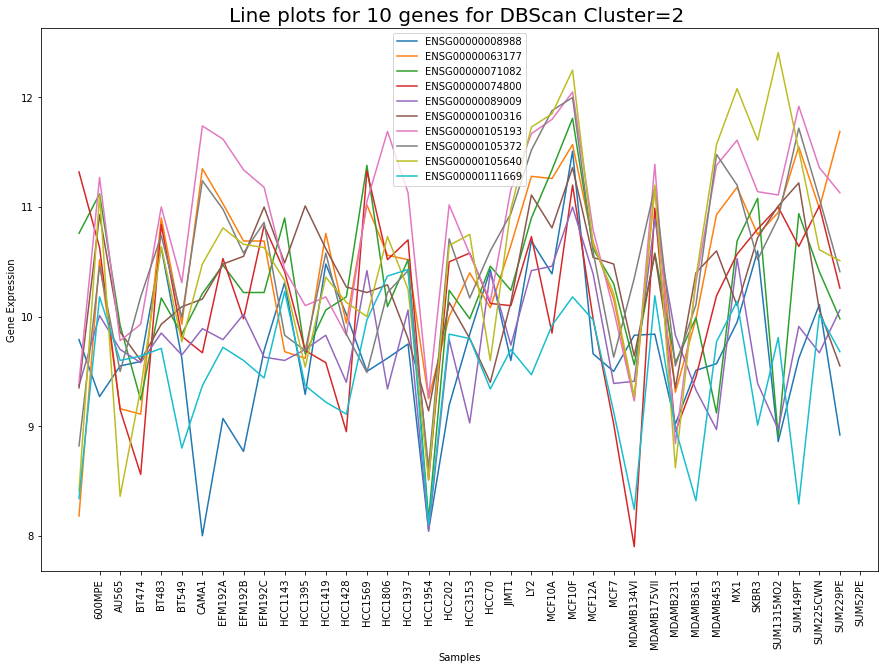

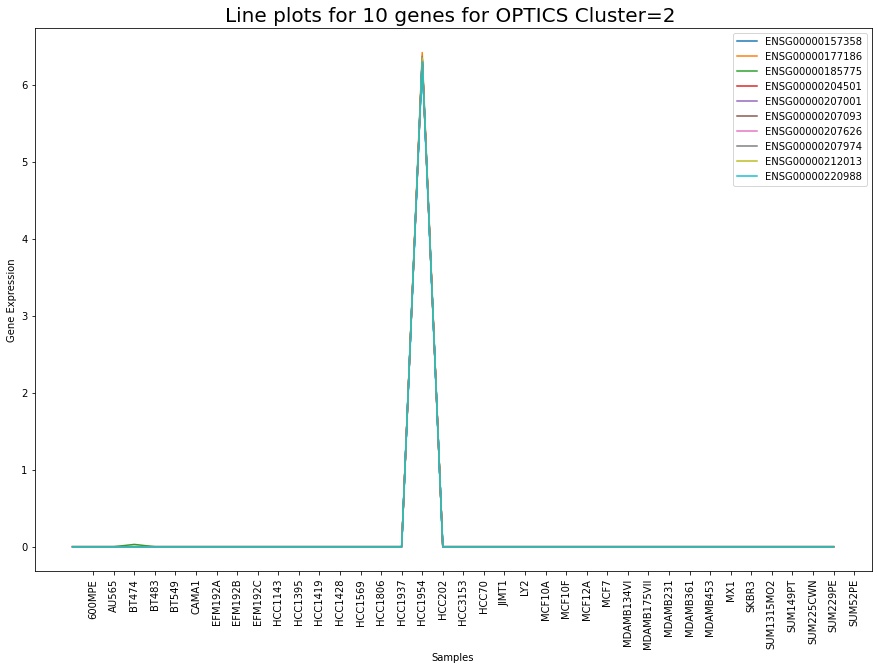

In [ ]:
#Draw line plots
labs = nd10_k_t1.index.values
x_values = np.arange(1, len(labs) + 1, 1)

#plt.figure(figsize=(15, 10))
nd10_k_t1.plot.line(figsize=(15, 10))
plt.xlabel('Samples')
plt.ylabel('Gene Expression')
plt.title("Line plots for 10 genes for Kmean Cluster=2 ", fontsize=20)
plt.xticks(x_values, labs, rotation=90)


#Draw DB Scan line  plots
#plt.figure(figsize=(15, 10))
nd10_d_t1.plot.line(figsize=(15, 10))
plt.xlabel('Samples')
plt.ylabel('Gene Expression')
plt.title("Line plots for 10 genes for DBScan Cluster=2 ", fontsize=20)
plt.xticks(x_values, labs, rotation=90)


#Draw line plots for OPTICS
#plt.figure(figsize=(15, 10))
nd10_o_t1.plot.line(figsize=(15, 10))
plt.xlabel('Samples')
plt.ylabel('Gene Expression')
plt.title("Line plots for 10 genes for OPTICS Cluster=2 ", fontsize=20)
plt.xticks(x_values, labs, rotation=90)

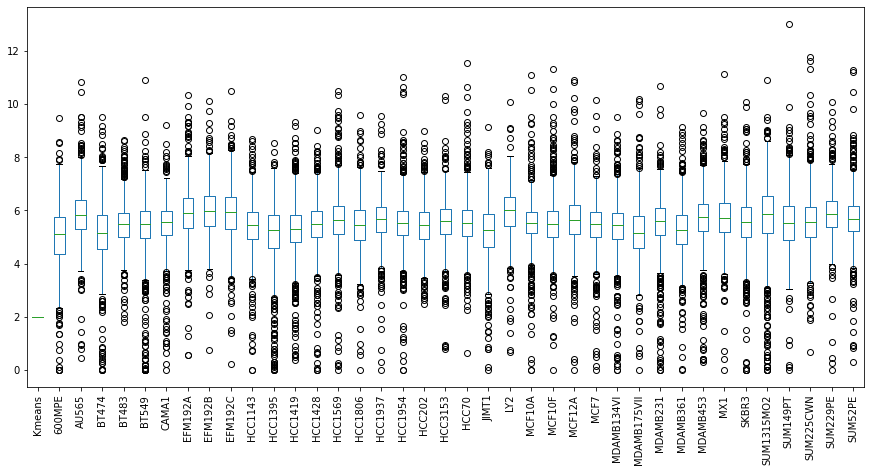

In [ ]:
#Take first 10 genes (Note: you can take all genes of a cluster,)
nd10_k = nd1
nd10_d = nd2
nd10_o = nd3

nd10_k = nd10_k.astype(float)

#Boxplot plot
nd10_k.groupby(['Kmeans']).plot.box(figsize=(15,7), rot=90);

In [ ]:
new_full_df = df_full1.head(10)
new_full_df

,Kmeans,DBScan,OPTICS,PC1,PC2,600MPE,AU565,BT474,BT483,BT549,CAMA1,EFM192A,EFM192B,EFM192C,HCC1143,HCC1395,HCC1419,HCC1428,HCC1569,HCC1806,HCC1937,HCC1954,HCC202,HCC3153,HCC70,JIMT1,LY2,MCF10A,MCF10F,MCF12A,MCF7,MDAMB134VI,MDAMB175VII,MDAMB231,MDAMB361,MDAMB453,MX1,SKBR3,SUM1315MO2,SUM149PT,SUM225CWN,SUM229PE,SUM52PE
ENSG00000000419,2,-1,-1,6.553436,-0.372788,5.32,5.3,6.64,5.6,6.61,5.24,6.66,6.62,6.41,5.19,6.16,7.29,4.78,6.14,5.66,5.8,6.2,4.69,6.5,5.49,7.29,5.23,5.63,4.82,5.64,6.07,4.79,6.25,5.19,5.8,4.63,5.98,6.19,4.97,4.15,5.82,6.4,4.67
ENSG00000001036,2,-1,-1,4.579762,1.339591,6.11,4.8,4.47,4.99,6.94,5,5.11,5.42,4.58,4.74,6.03,5.47,4.32,6.16,5.89,5.37,6.01,4.72,5.17,5.96,6.35,5.02,5.31,6.37,5.24,6.29,5.81,4.16,6.56,5.91,5.19,4,5.48,4.14,5.9,5.51,5.14,6.22
ENSG00000001084,7,-1,-1,1.906375,0.750737,5.78,4.01,5.14,5.11,3.63,5.93,4.11,3.68,3.23,5.01,5.81,4.5,5.17,5.61,6.19,5.02,6.79,5.97,4.77,5.85,4.78,4.27,6.8,6.25,4.5,5.08,5.21,4.24,4.12,6,4.16,3.19,4.29,3.95,5.26,6.63,4.38,6.38
ENSG00000001497,2,0,0,4.376390,0.526701,4.93,6.16,5.36,5.1,6.16,5.5,6.1,6.88,5.99,6.69,5.03,5.33,6.46,4.99,5.49,5.47,5.95,4.04,4.63,4.97,6.12,4.77,5.31,4.79,5.62,5.11,5.34,4.2,5.47,3.92,5.14,5.95,4.74,4.95,5.26,4.69,6.16,5.11
ENSG00000001617,8,-1,-1,1.313118,-5.746566,4.06,7.53,4.7,6.69,3.3,5.39,6.55,6.41,5.26,1.76,3.94,4.74,4.67,2.71,3.33,5.04,5.33,5.5,5.05,5.83,3.86,7.31,5.13,5.15,5.23,5.51,6.76,5.12,1.12,5.49,7.74,1.38,6.81,1.71,4.8,3.8,5.59,5.27
ENSG00000001630,2,-1,-1,4.085574,-1.136459,6.74,5.15,6.14,5.27,3.88,5.81,4.99,4.32,3.85,4.79,5.8,4.28,4.78,6.17,4.32,3.92,5.09,5.2,5.66,7.05,4.56,5.44,5.92,4.63,5.9,5.84,5.91,7.35,5.39,5.37,4.7,4.78,5.37,4.06,4.27,7.08,5.49,8.1
ENSG00000001631,7,-1,-1,-4.424625,-1.113958,4.8,3.56,4.14,4.47,3.14,4.61,3.18,3.23,2.51,2.37,5.36,3.44,4.57,4.42,3.64,3.97,3.31,4.85,4.5,4.49,3.94,4.13,4.2,2.85,3.2,3.76,4.29,4.48,3.73,4.12,4.04,3.35,4.2,2.89,4,5.13,3.86,6.53
ENSG00000002330,0,-1,0,8.632955,0.401111,4.2,6.69,5.81,5.39,5.94,4.88,6.91,5.81,6.64,5.77,5.38,7,5.9,5.92,5.84,5.78,5.68,5.81,6.56,5.4,6.05,7.05,6.54,6.72,6.11,5.6,4.93,4.99,6.8,5.53,6.3,6.81,7.38,6.37,6.56,7,5.73,6.74
ENSG00000002549,2,-1,0,3.777017,-0.061881,5.13,4.96,4.72,5.8,5.57,5.69,5.41,4.81,4.5,5.36,5.2,6.56,4.82,6.46,5.34,5.86,6.02,5.24,5.41,6.93,4.7,5.73,5.31,5.65,5,5.59,5.97,4.82,6.05,5.55,4.86,3.95,4.84,4.02,4.92,5.46,4.6,4.56
ENSG00000002586,0,-1,-1,11.478314,0.559462,5.57,6.55,7.52,6.31,7.93,5.36,7.66,6.88,8.88,4.75,7.6,6.17,7.44,5.74,5.79,5.84,8.23,4.95,7.31,5.77,5.4,6.56,7.38,7.85,6.8,5.76,5.42,4.96,7.29,6.93,6.8,6.53,4.96,7.24,5.73,6.98,5.89,6.74


In [ ]:
new_full_df1 = new_full_df.astype(float)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


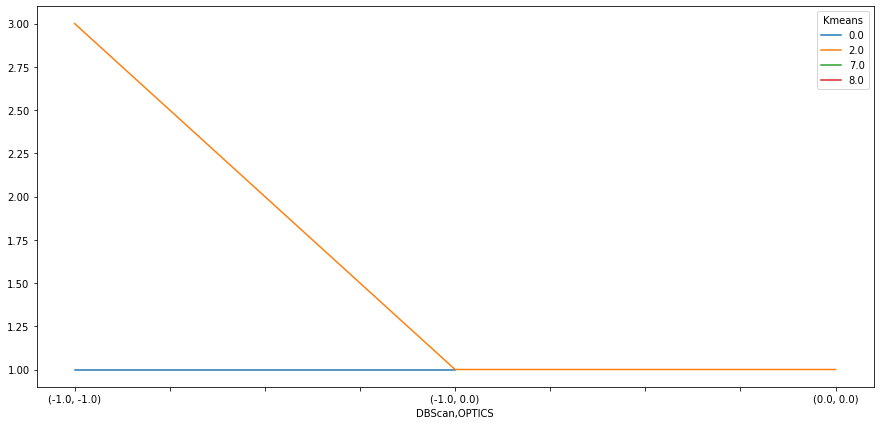

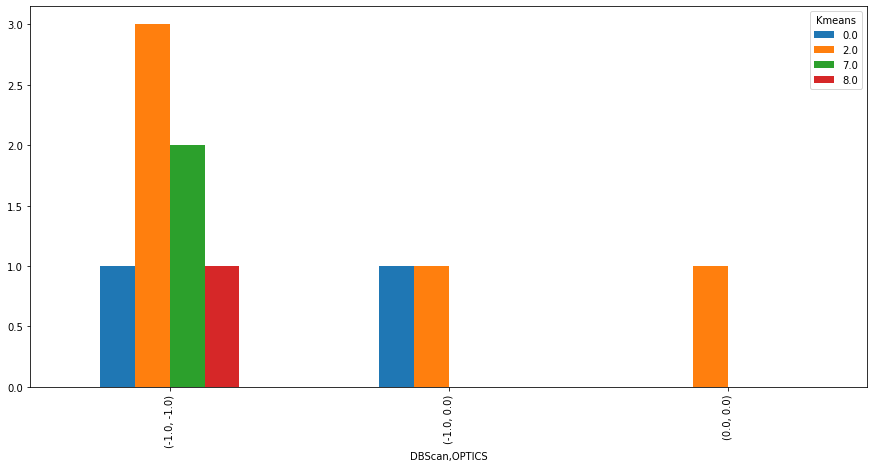

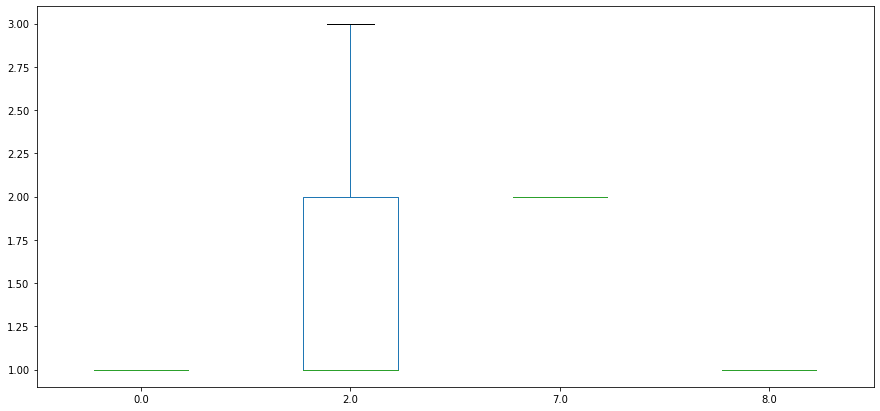

In [ ]:
#Plots for 3 types of clustering for specific sample

#Line plot for a single sample 
new_full_df1.groupby(['Kmeans','DBScan', 'OPTICS'])['AU565'].count().unstack('Kmeans').plot(figsize=(15,7));

#Barplot for a sample
new_full_df1.groupby(['Kmeans','DBScan', 'OPTICS'])['AU565'].count().unstack('Kmeans').plot.bar(figsize=(15,7));

#Boxplot plot for a single sample 
new_full_df1.groupby(['Kmeans','DBScan', 'OPTICS'])['AU565'].count().unstack('Kmeans').plot.box(figsize=(15,7));